<a href="https://colab.research.google.com/github/shizuo-kaji/DemoFeatureInvariance/blob/main/colab_regression_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab-ready demo: Triangle regression and representation experiments

This notebook is a self-contained reproduction of the regression demo. It:

- Generates a synthetic triangle dataset (three 2D points per sample).
- Computes three targets per triangle: u (centroid sum), v (area), w (sum of squared angles).
- Provides preprocessing/feature modes: `none`, `congruent`, `similar`, `length`, `angle`.
- Trains multiple regressors and reports MSE / MAE / R2.

Notes for Colab:
- Run cells in order. Install the required packages (next cell) if needed.
- Adjust `N_SAMPLES` and `MODES_TO_RUN` in the main run cell to manage runtime.

In [1]:
# Section 1 — Colab runtime & environment checks

import sys
print('Python', sys.version)

# GPU check (works if runtime has GPU attached). Wrap in try/except to avoid noisy errors on CPU runtimes.
try:
    import subprocess
    r = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if r.returncode == 0:
        print(r.stdout)
    else:
        print('nvidia-smi not available or no GPU attached (return code', r.returncode, ')')
except Exception as e:
    print('GPU check skipped or not available:', e)


Python 3.13.7 | packaged by conda-forge | (main, Sep  3 2025, 14:24:46) [Clang 19.1.7 ]
GPU check skipped or not available: [Errno 2] No such file or directory: 'nvidia-smi'


In [ ]:
# Section 2 — Install dependencies (run once per session)

# On Colab, use the %pip magic for reliable installs in the running kernel. The `-q` flag keeps output cleaner.
%pip install -q numpy pandas scikit-learn matplotlib seaborn

# If you want to use widgets later (optional), uncomment the next line
# %pip install -q ipywidgets


In [2]:
# Section 4 — Imports and configuration

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style='whitegrid')
np.random.seed(0)


In [3]:
# Section 5 — Helper functions: geometry and targets

def area_triangle(p1, p2, p3):
    # shoelace formula
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    return 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))

def centroid_sum(p1, p2, p3):
    cx = (p1[0] + p2[0] + p3[0]) / 3.0
    cy = (p1[1] + p2[1] + p3[1]) / 3.0
    return cx + cy

def angle_at(a, b, c):
    # angle at vertex b in triangle a-b-c
    ba = (a[0]-b[0], a[1]-b[1])
    bc = (c[0]-b[0], c[1]-b[1])
    dot = ba[0]*bc[0] + ba[1]*bc[1]
    lena = math.hypot(ba[0], ba[1])
    lenc = math.hypot(bc[0], bc[1])
    if lena == 0 or lenc == 0:
        return float('nan')
    cosang = max(-1.0, min(1.0, dot / (lena*lenc)))
    return math.acos(cosang)

def sum_squared_angles(p1, p2, p3):
    a1 = angle_at(p2, p1, p3)
    a2 = angle_at(p1, p2, p3)
    a3 = angle_at(p1, p3, p2)
    if any(math.isnan(x) for x in (a1,a2,a3)):
        return float('nan')
    return a1*a1 + a2*a2 + a3*a3


def generate_triangle_dataset(n=2000, xmin=-10, xmax=10, ymin=-10, ymax=10, min_area=1e-3, seed=0):
    rng = np.random.RandomState(seed)
    rows = []
    attempts = 0
    while len(rows) < n and attempts < n*20:
        attempts += 1
        x1 = rng.uniform(xmin, xmax)
        y1 = rng.uniform(ymin, ymax)
        x2 = rng.uniform(xmin, xmax)
        y2 = rng.uniform(ymin, ymax)
        x3 = rng.uniform(xmin, xmax)
        y3 = rng.uniform(ymin, ymax)
        p1 = (x1,y1); p2=(x2,y2); p3=(x3,y3)
        area = area_triangle(p1,p2,p3)
        if area < min_area:
            continue
        u = centroid_sum(p1,p2,p3)
        v = area
        w = sum_squared_angles(p1,p2,p3)
        if math.isnan(w):
            continue
        rows.append({'x1':x1,'y1':y1,'x2':x2,'y2':y2,'x3':x3,'y3':y3,'u':u,'v':v,'w':w})
    df = pd.DataFrame(rows)
    return df

print('Helper functions defined')


Helper functions defined


In [4]:
# Section 6 — Preprocessing / feature transforms

import numpy.linalg as la

def congruent_transform_row(x1,y1,x2,y2,x3,y3):
    # translate so p1 -> (0,0)
    p1 = np.array([x1,y1])
    p2 = np.array([x2,y2]) - p1
    p3 = np.array([x3,y3]) - p1
    # rotate such that p2 lies on positive x-axis
    ang = math.atan2(p2[1], p2[0])
    c, s = math.cos(-ang), math.sin(-ang)
    R = np.array([[c, -s],[s, c]])
    p2r = R.dot(p2)
    p3r = R.dot(p3)
    # ensure p3 has non-negative y (flip if needed)
    if p3r[1] < 0:
        p3r[1] *= -1
    return [float(p2r[0]), float(p3r[0]), float(p3r[1])]
    #return [0.0, 0.0, float(p2r[0]), float(p2r[1]), float(p3r[0]), float(p3r[1])]

def similar_transform_row(x1,y1,x2,y2,x3,y3):
    coords = congruent_transform_row(x1,y1,x2,y2,x3,y3)
    # coords are [0,0,x2,y2,x3,y3]; scale so p2 -> (1,0)
    x2r = coords[0]
    if x2r == 0:
        s = 1.0
    else:
        s = 1.0 / x2r
    #coords_scaled = [coords[0],coords[1], coords[2]*s, coords[3]*s, coords[4]*s, coords[5]*s]
    coords_scaled = [coords[1]*s, coords[2]*s]
    return coords_scaled

def coords_to_length_df(df):
    def lens(row):
        p1 = (row['x1'], row['y1'])
        p2 = (row['x2'], row['y2'])
        p3 = (row['x3'], row['y3'])
        l_a = math.hypot(p2[0]-p3[0], p2[1]-p3[1])
        l_b = math.hypot(p1[0]-p3[0], p1[1]-p3[1])
        l_c = math.hypot(p1[0]-p2[0], p1[1]-p2[1])
        return pd.Series([l_a,l_b,l_c])
    out = df.apply(lens, axis=1)
    out.columns = ['l_a','l_b','l_c']
    return out

def coords_to_angle_df(df):
    def angs(row):
        p1=(row['x1'],row['y1']); p2=(row['x2'],row['y2']); p3=(row['x3'],row['y3'])
        a1 = angle_at(p2,p1,p3)  # at p1
        a2 = angle_at(p1,p2,p3)  # at p2
        return pd.Series([a1,a2])
    out = df.apply(angs, axis=1)
    out.columns = ['ang1','ang2']
    return out

print('Preprocessing functions ready')


Preprocessing functions ready


In [5]:
# Section 7 — Feature dispatcher (returns X, y)

def get_features_and_targets(df, mode='none'):
    df_coords = df[['x1','y1','x2','y2','x3','y3']].copy()
    y = df[['u','v','w']].copy()
    if mode == 'none':
        X = df_coords.copy()
    elif mode == 'congruent':
        rows = df_coords.apply(lambda r: congruent_transform_row(r.x1,r.y1,r.x2,r.y2,r.x3,r.y3), axis=1)
        X = pd.DataFrame(rows.tolist())
    elif mode == 'similar':
        rows = df_coords.apply(lambda r: similar_transform_row(r.x1,r.y1,r.x2,r.y2,r.x3,r.y3), axis=1)
        X = pd.DataFrame(rows.tolist())
    elif mode == 'length':
        X = coords_to_length_df(df)
    elif mode == 'angle':
        X = coords_to_angle_df(df)
    else:
        raise ValueError('Unknown mode: '+str(mode))
    # Drop rows with NaNs (from degenerate cases)
    mask = X.notnull().all(axis=1) & y.notnull().all(axis=1)
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    return X, y

print('Feature dispatcher ready')


Feature dispatcher ready


In [ ]:
# Section 8 — Model training/evaluation helpers

def build_regressors():
    return {
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
        "SVR": SVR(C=1.0, kernel="rbf"),
        "KNN": KNeighborsRegressor(n_neighbors=5),
        "MLP": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=5000, random_state=0),
    }

from IPython.display import display

def train_and_evaluate(X_train, y_train, X_test, y_test, regressors=None, targets=['u','v','w'], out_prefix='results'):
    """Train and evaluate regressors, returning results and predictions for later plotting."""
    if regressors is None:
        regressors = build_regressors()
    rows = []
    predictions = {}  # Store predictions for combined plotting

    for target in targets:
        ytr = y_train[target].values
        yte = y_test[target].values
        predictions[target] = {}

        for name, reg in regressors.items():
            pipe = make_pipeline(StandardScaler(), reg)
            pipe.fit(X_train, ytr)
            pred = pipe.predict(X_test)
            mse = mean_squared_error(yte, pred)
            mae = mean_absolute_error(yte, pred)
            r2 = r2_score(yte, pred)
            rows.append({'target':target,'regressor':name,'MSE':mse,'MAE':mae,'R2':r2})

            # Store predictions for combined plotting
            predictions[target][name] = {'true': yte, 'pred': pred, 'r2': r2}

    results = pd.DataFrame(rows)
    return results, predictions

def plot_predictions_combined(all_predictions, mode, targets=['u','v','w']):
    """Create a combined plot grid for all regressors and targets for a given mode."""
    regressors = list(next(iter(all_predictions.values())).keys())
    n_regressors = len(regressors)
    n_targets = len(targets)

    fig, axes = plt.subplots(n_targets, n_regressors, figsize=(4*n_regressors, 4*n_targets))
    if n_targets == 1:
        axes = axes.reshape(1, -1)
    if n_regressors == 1:
        axes = axes.reshape(-1, 1)

    for i, target in enumerate(targets):
        for j, regressor in enumerate(regressors):
            ax = axes[i, j]
            data = all_predictions[target][regressor]
            yte = data['true']
            pred = data['pred']
            r2 = data['r2']

            ax.scatter(yte, pred, alpha=0.4, s=20)
            mn = min(min(yte), min(pred))
            mx = max(max(yte), max(pred))
            ax.plot([mn,mx],[mn,mx],'r--', linewidth=1)
            ax.set_xlabel('True', fontsize=10)
            ax.set_ylabel('Predicted', fontsize=10)
            ax.set_title(f'{target} — {regressor} (R²={r2:.3f})', fontsize=11)
            ax.grid(True, alpha=0.3)

    plt.suptitle(f'Mode: {mode}', fontsize=14, fontweight='bold', y=1.002)
    plt.tight_layout()
    plt.show()

print('Training/evaluation helpers ready')


Training/evaluation helpers ready


Generating dataset with 1500 samples...
Generated 1500 valid triangles (after rejecting degenerate samples)

--- Running mode: none
Features shape: (1500, 6) Targets shape: (1500, 3)


,target,regressor,MSE,MAE,R2,mode
0,u,Linear,4.851757e-29,5.567028e-15,1.000000,none
1,u,Ridge,1.570079e-05,3.236316e-03,0.999999,none
2,u,MLP,1.192442e-02,8.349563e-02,0.999466,none
3,u,SVR,1.770171e-01,2.184973e-01,0.992078,none
4,u,KNN,1.215495e+00,8.569174e-01,0.945606,none
5,u,RandomForest,1.689924e+00,1.041579e+00,0.924375,none
6,v,MLP,2.682865e+01,3.967030e+00,0.965686,none
7,v,KNN,2.233712e+02,1.129752e+01,0.714305,none
8,v,RandomForest,4.150695e+02,1.565219e+01,0.469119,none
9,v,SVR,5.586648e+02,1.668642e+01,0.285459,none


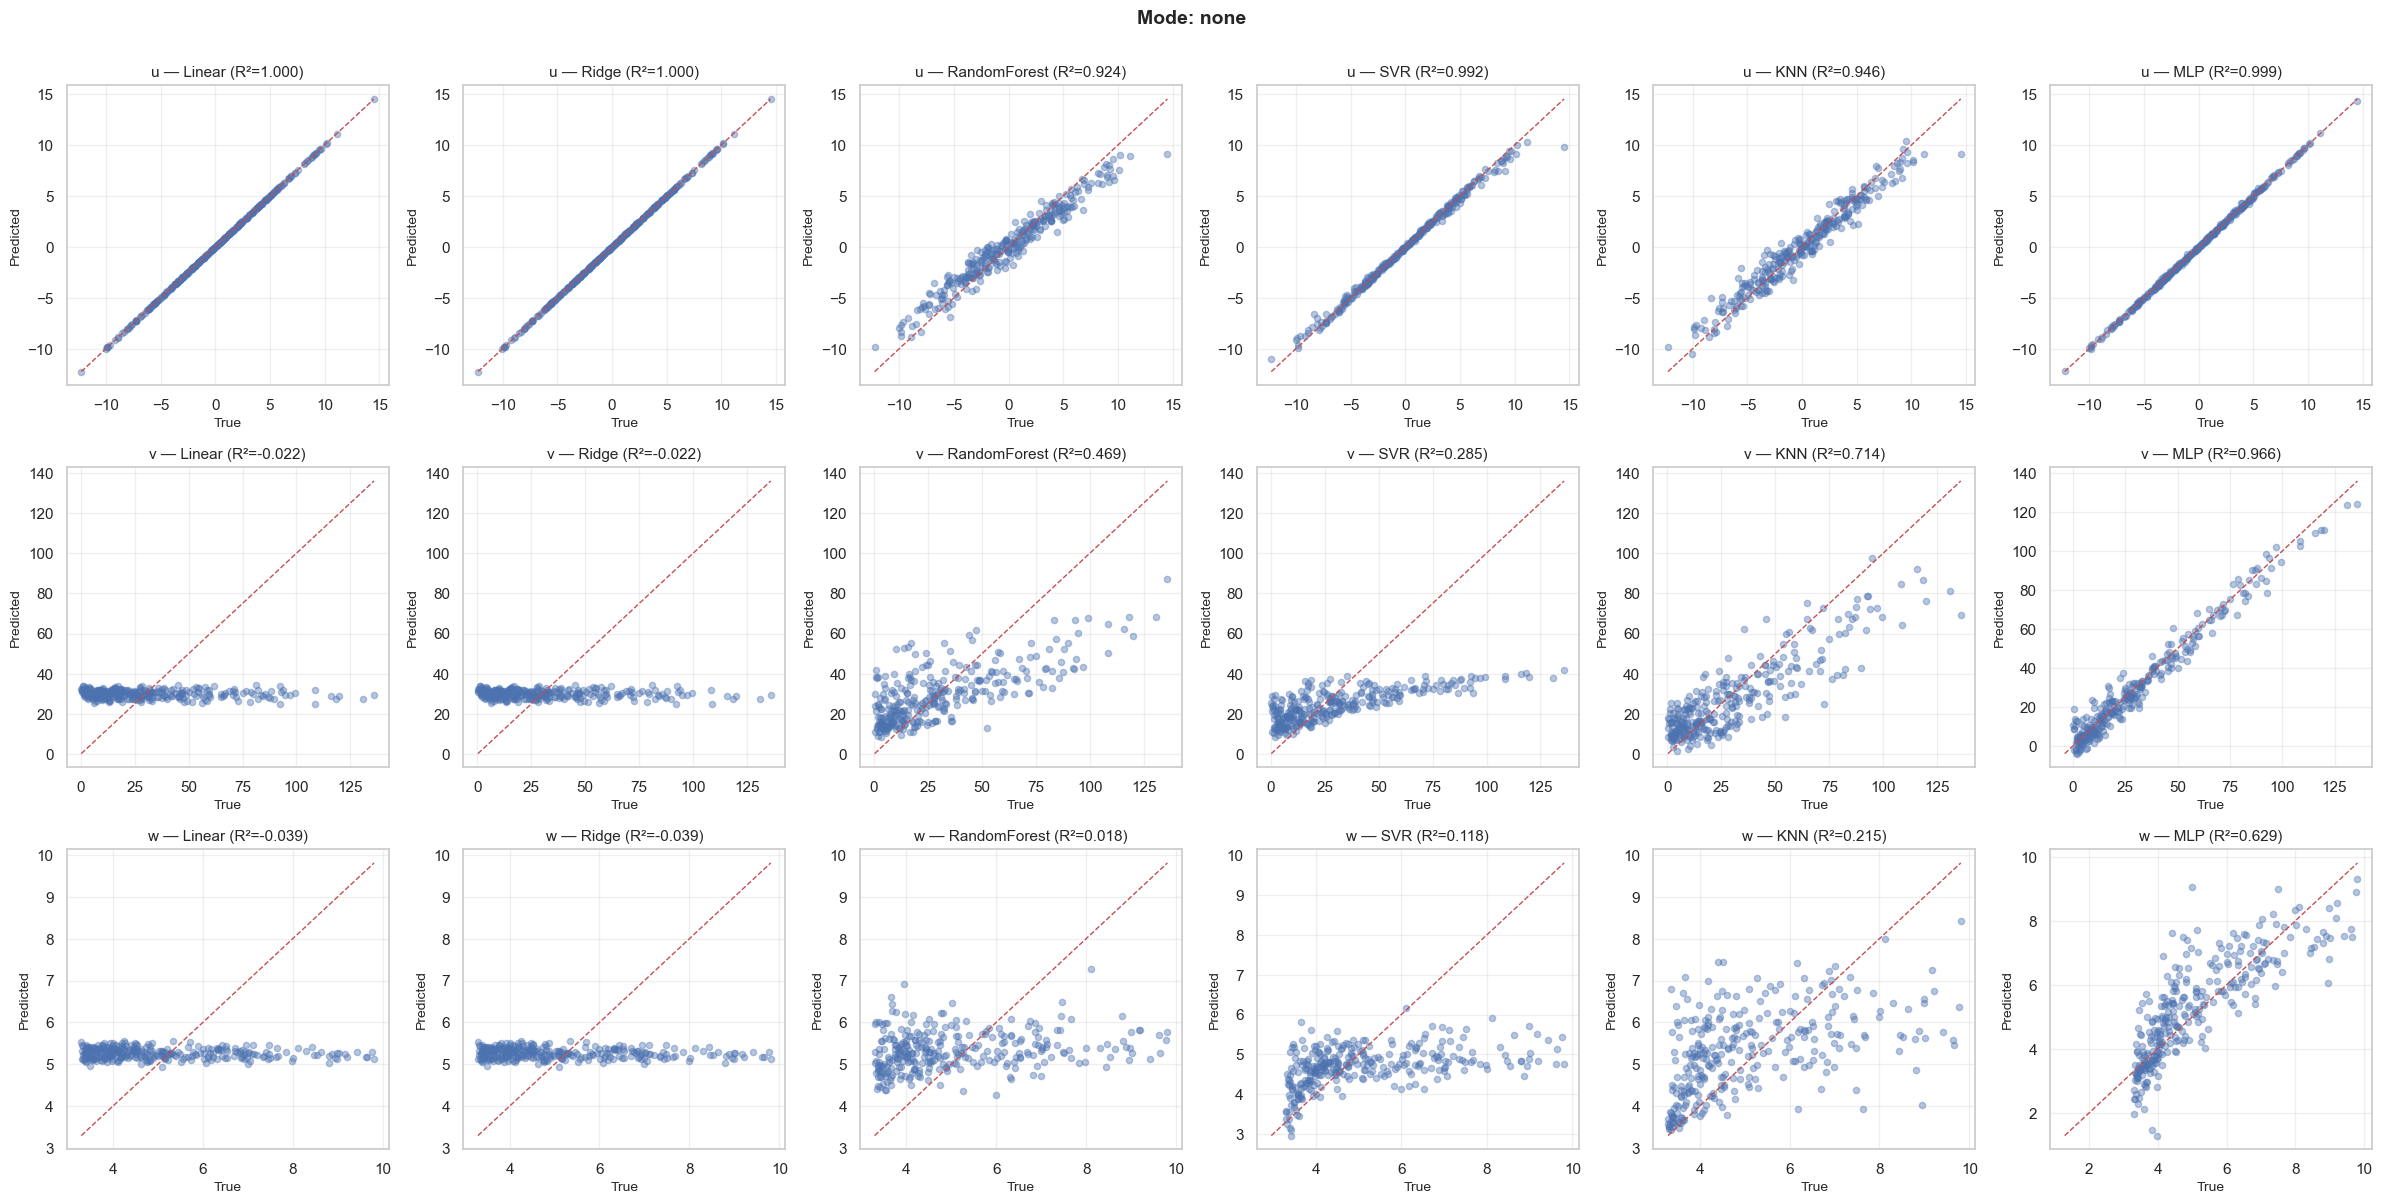


--- Running mode: congruent
Features shape: (1500, 3) Targets shape: (1500, 3)


,target,regressor,MSE,MAE,R2,mode
0,u,Ridge,22.388055,3.840215,-0.001877,congruent
1,u,Linear,22.388228,3.840223,-0.001884,congruent
2,u,SVR,23.715989,3.961133,-0.061302,congruent
3,u,MLP,25.288279,4.045655,-0.131663,congruent
4,u,RandomForest,26.554977,4.122469,-0.188349,congruent
5,u,KNN,29.226644,4.287868,-0.307907,congruent
6,v,MLP,0.121388,0.256743,0.999845,congruent
7,v,RandomForest,5.128762,1.040490,0.993440,congruent
8,v,KNN,11.986165,2.385156,0.984669,congruent
9,v,SVR,61.265441,2.888174,0.921641,congruent


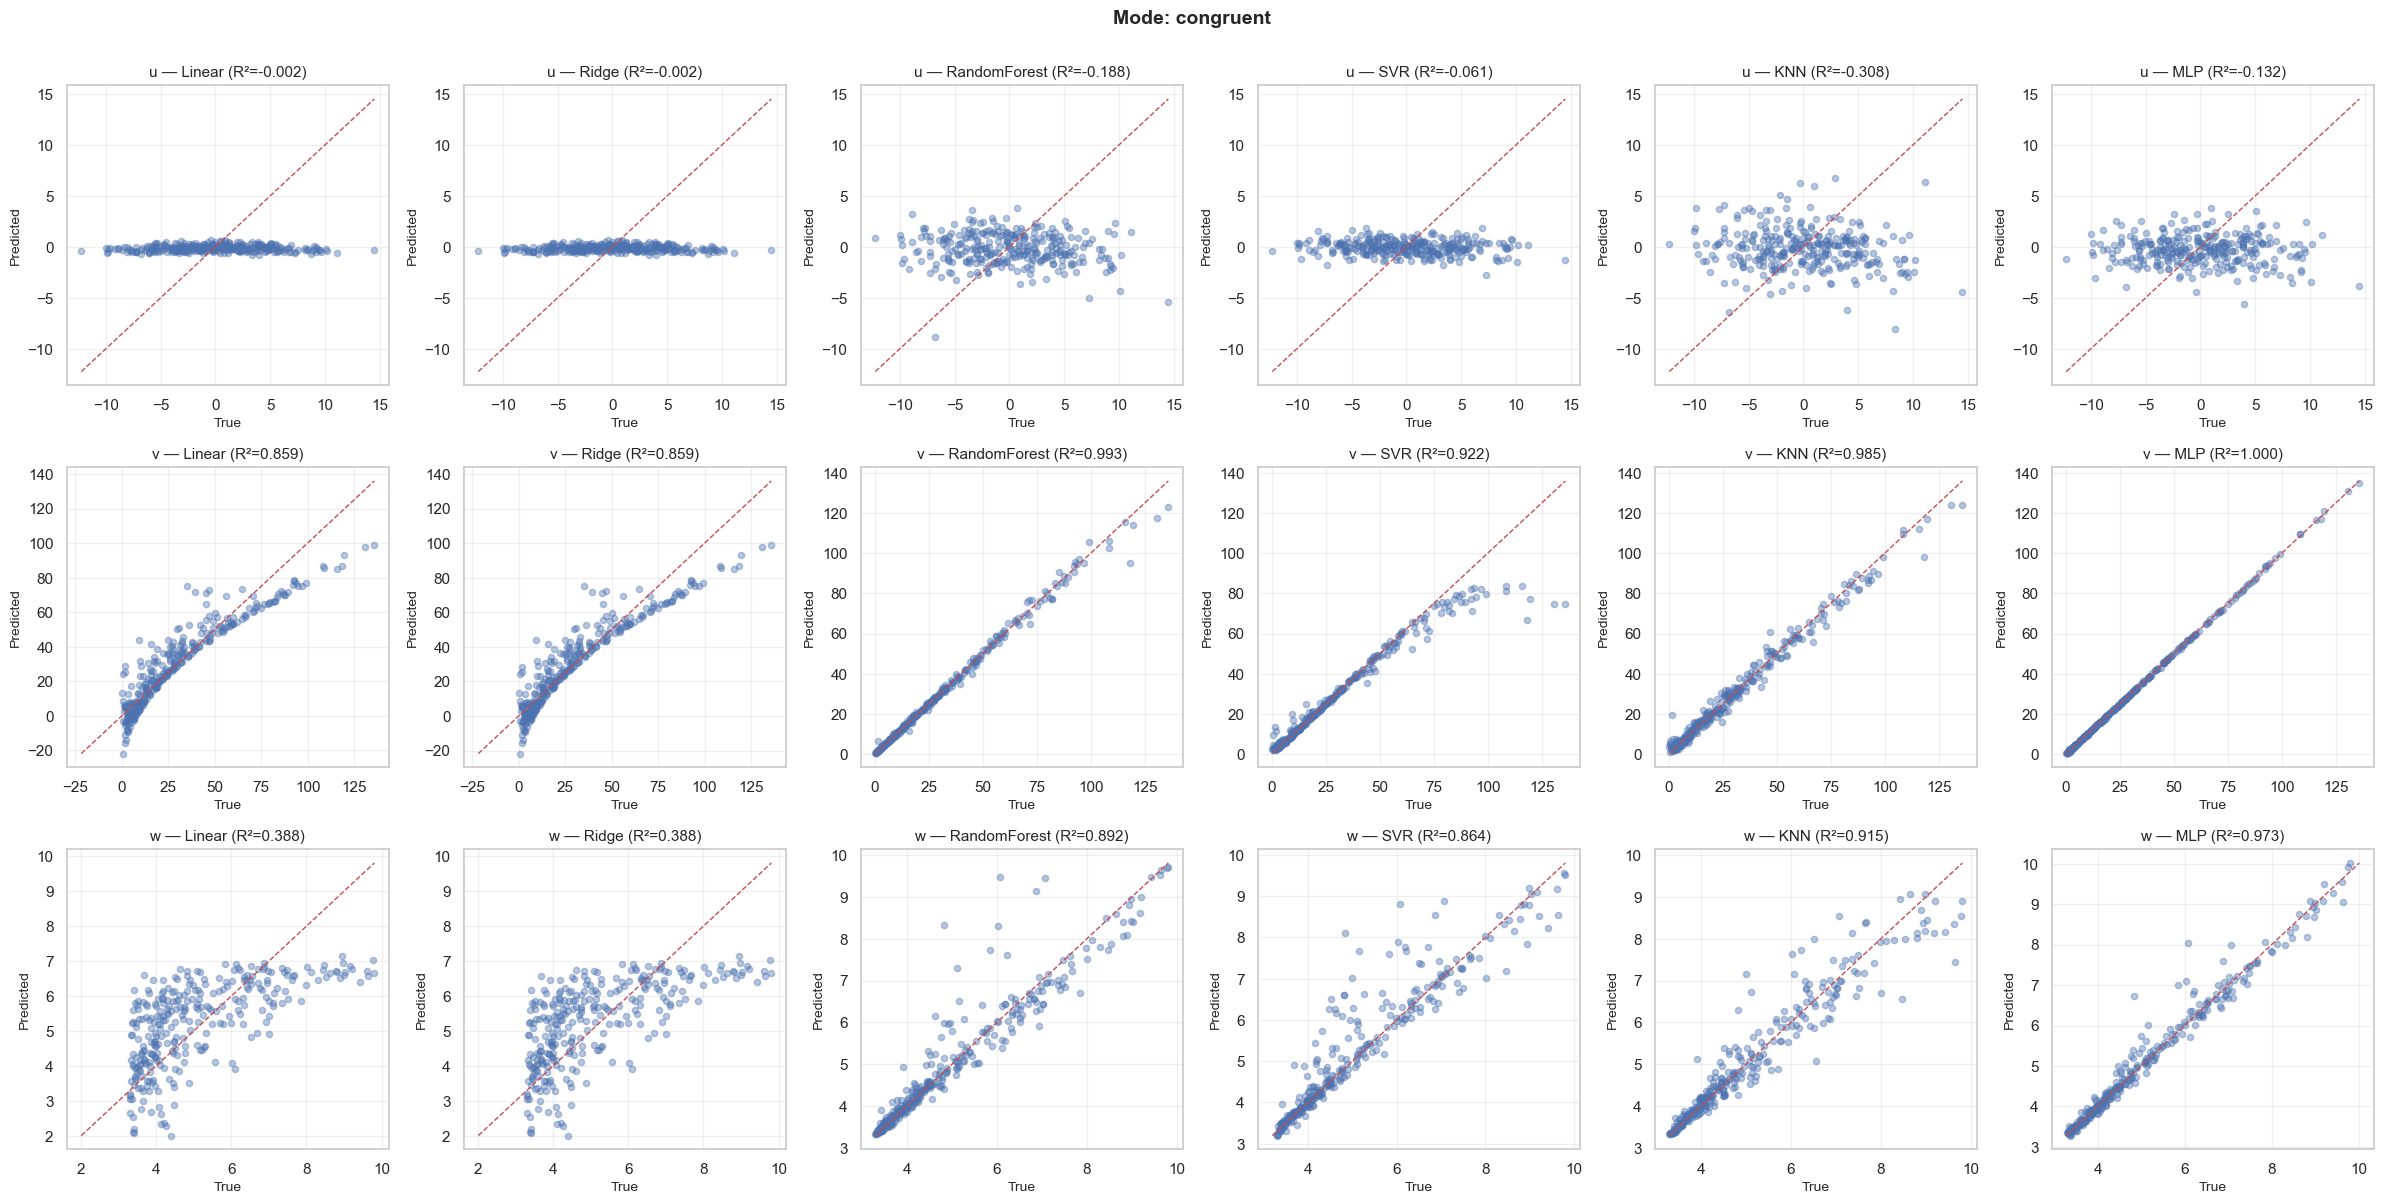


--- Running mode: similar
Features shape: (1500, 2) Targets shape: (1500, 3)


,target,regressor,MSE,MAE,R2,mode
0,u,Ridge,22.356422,3.849539,-0.000461,similar
1,u,Linear,22.356439,3.849550,-0.000462,similar
2,u,SVR,23.141546,3.930659,-0.035596,similar
3,u,RandomForest,26.916537,4.092670,-0.204529,similar
4,u,KNN,27.638586,4.192068,-0.236841,similar
5,u,MLP,27.805639,4.042257,-0.244316,similar
6,v,MLP,401.849641,14.628594,0.486028,similar
7,v,RandomForest,426.233411,14.611775,0.454841,similar
8,v,KNN,439.283305,14.775258,0.438150,similar
9,v,SVR,660.139571,17.721987,0.155671,similar


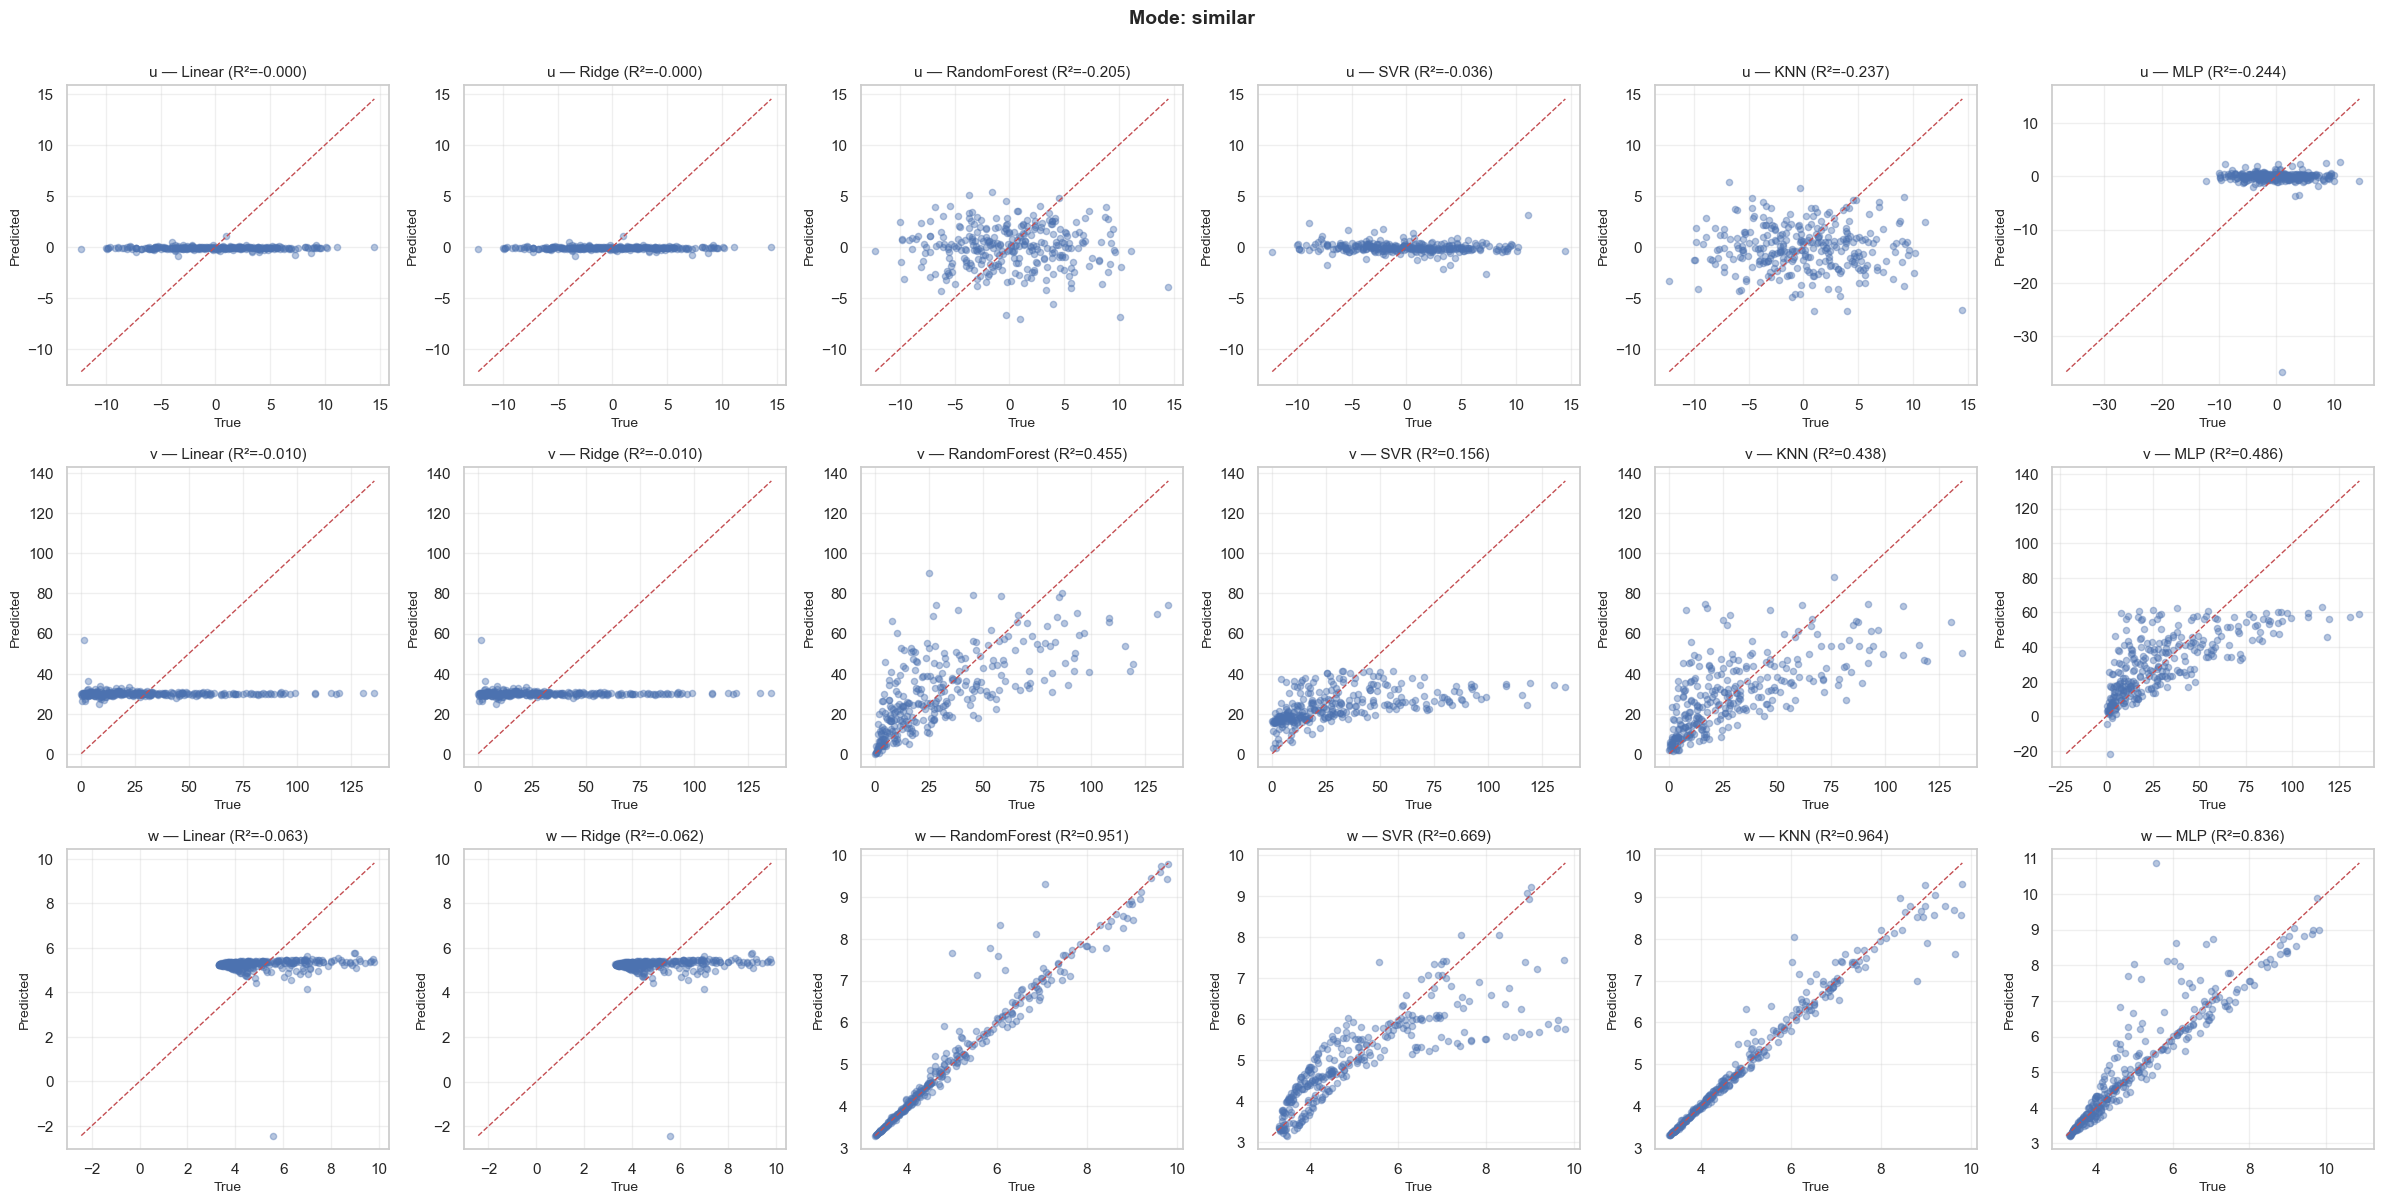


--- Running mode: length
Features shape: (1500, 3) Targets shape: (1500, 3)


,target,regressor,MSE,MAE,R2,mode
0,u,Ridge,22.617305,3.877557,-0.012136,length
1,u,Linear,22.617618,3.877588,-0.012150,length
2,u,SVR,23.939419,3.964121,-0.071301,length
3,u,MLP,24.733369,3.978234,-0.106831,length
4,u,RandomForest,27.724723,4.205105,-0.240695,length
5,u,KNN,31.668866,4.427864,-0.417198,length
6,v,MLP,2.562175,1.070339,0.996723,length
7,v,KNN,33.190766,3.970255,0.957548,length
8,v,RandomForest,33.460404,4.107751,0.957204,length
9,v,SVR,98.907961,5.945234,0.873495,length


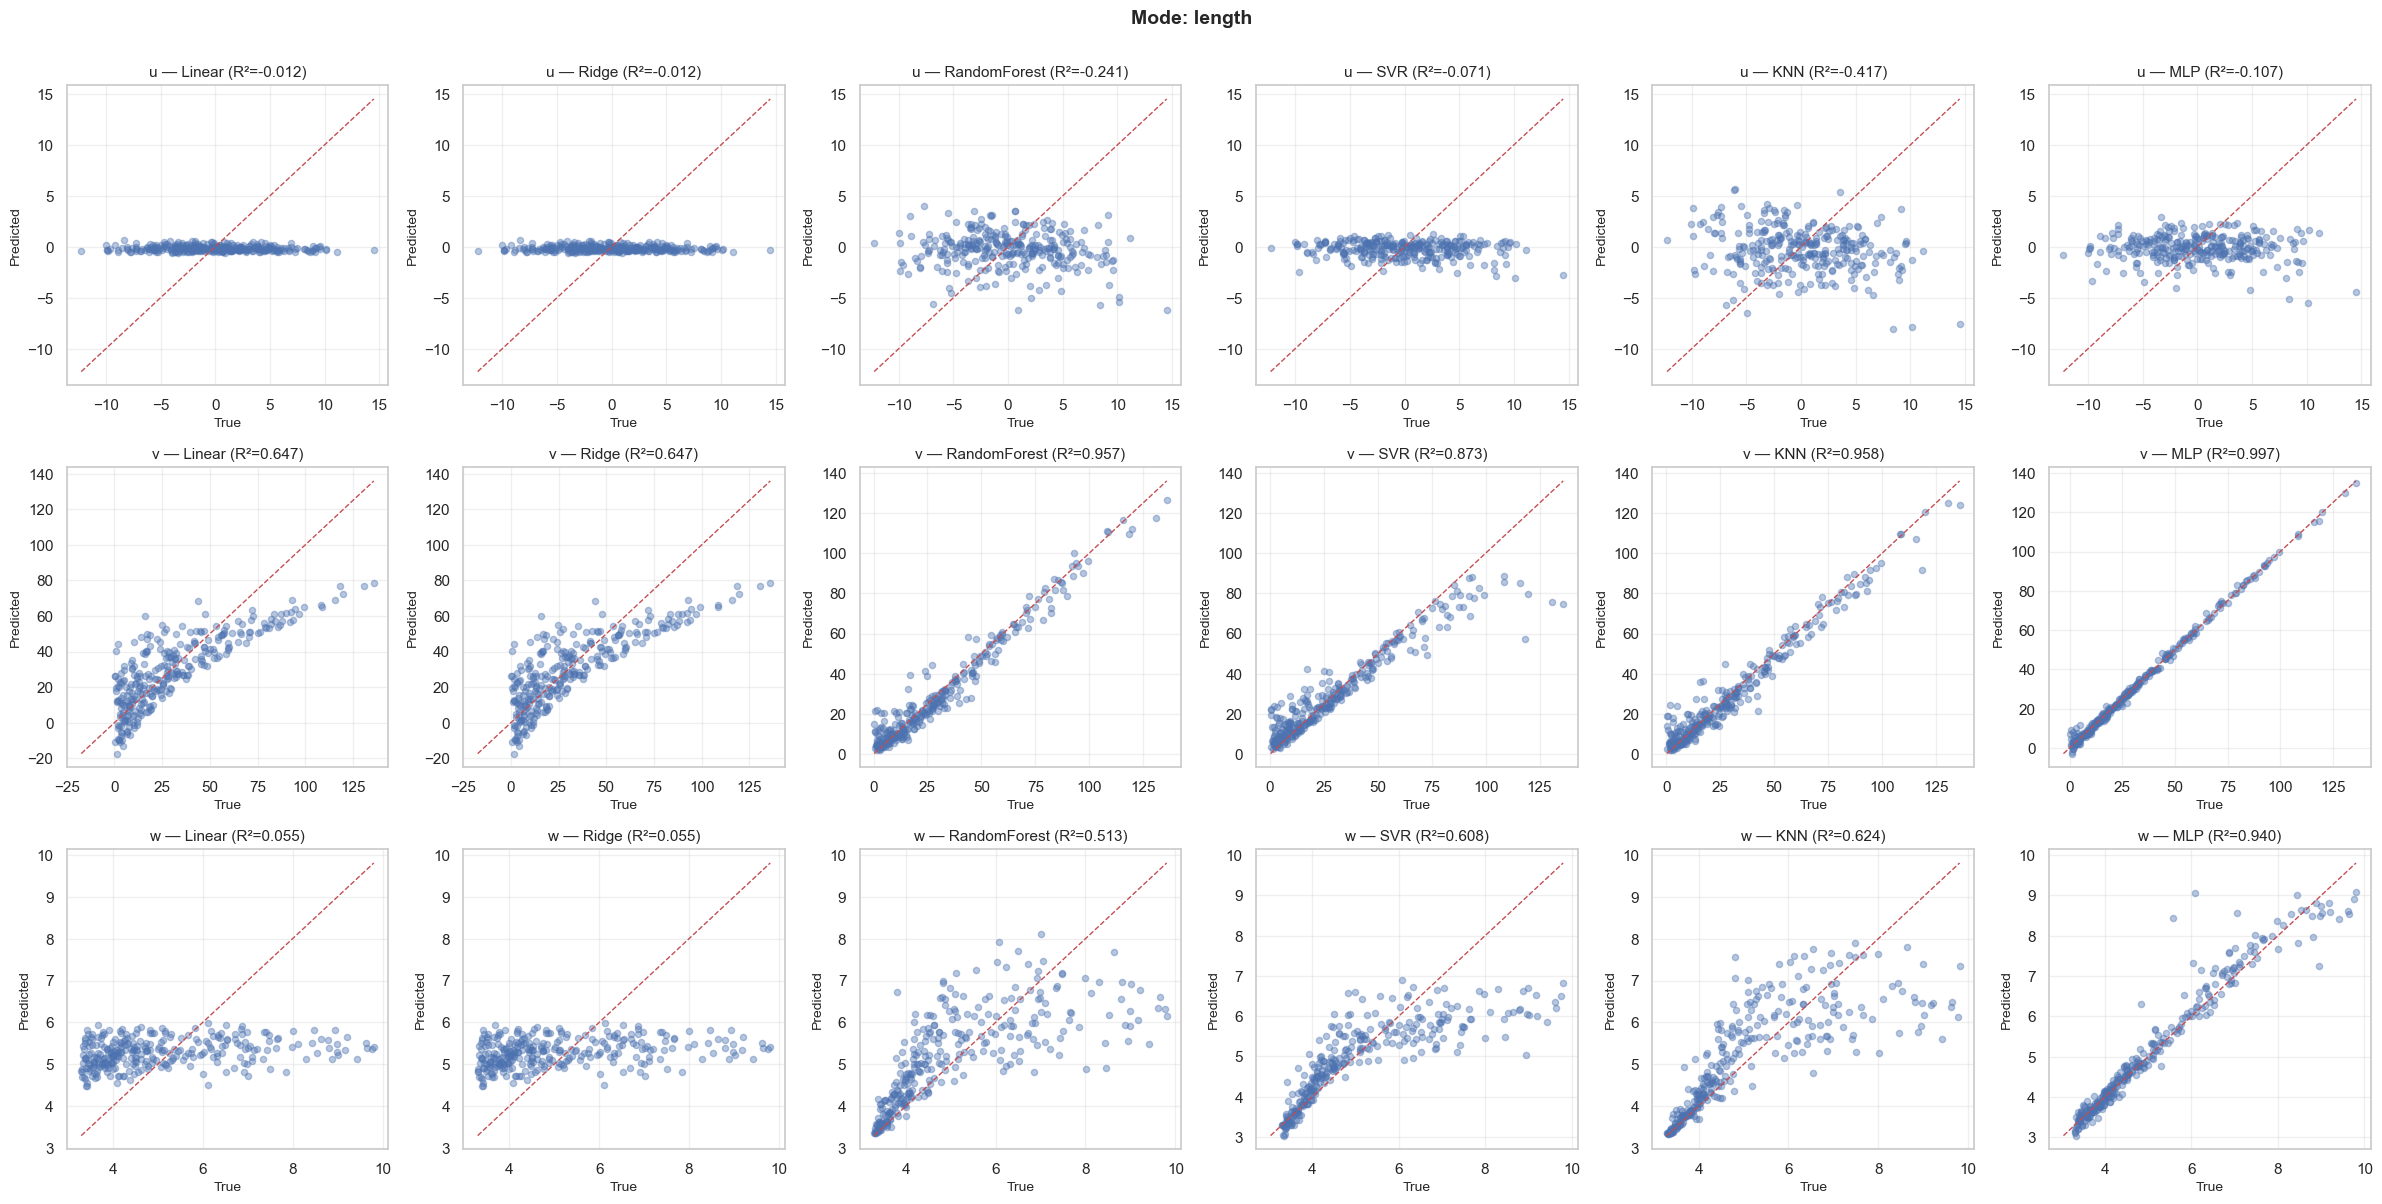


--- Running mode: angle
Features shape: (1500, 2) Targets shape: (1500, 3)


,target,regressor,MSE,MAE,R2,mode
0,u,Linear,22.222781,3.841035,0.005519,angle
1,u,Ridge,22.222886,3.841040,0.005515,angle
2,u,SVR,23.117924,3.903681,-0.034539,angle
3,u,MLP,23.465706,3.925119,-0.050102,angle
4,u,RandomForest,26.878457,4.149000,-0.202824,angle
5,u,KNN,26.899047,4.169301,-0.203746,angle
6,v,MLP,397.657861,14.512580,0.491389,angle
7,v,RandomForest,427.543255,15.066043,0.453165,angle
8,v,KNN,445.887068,15.031777,0.429703,angle
9,v,SVR,491.360499,15.497391,0.371542,angle


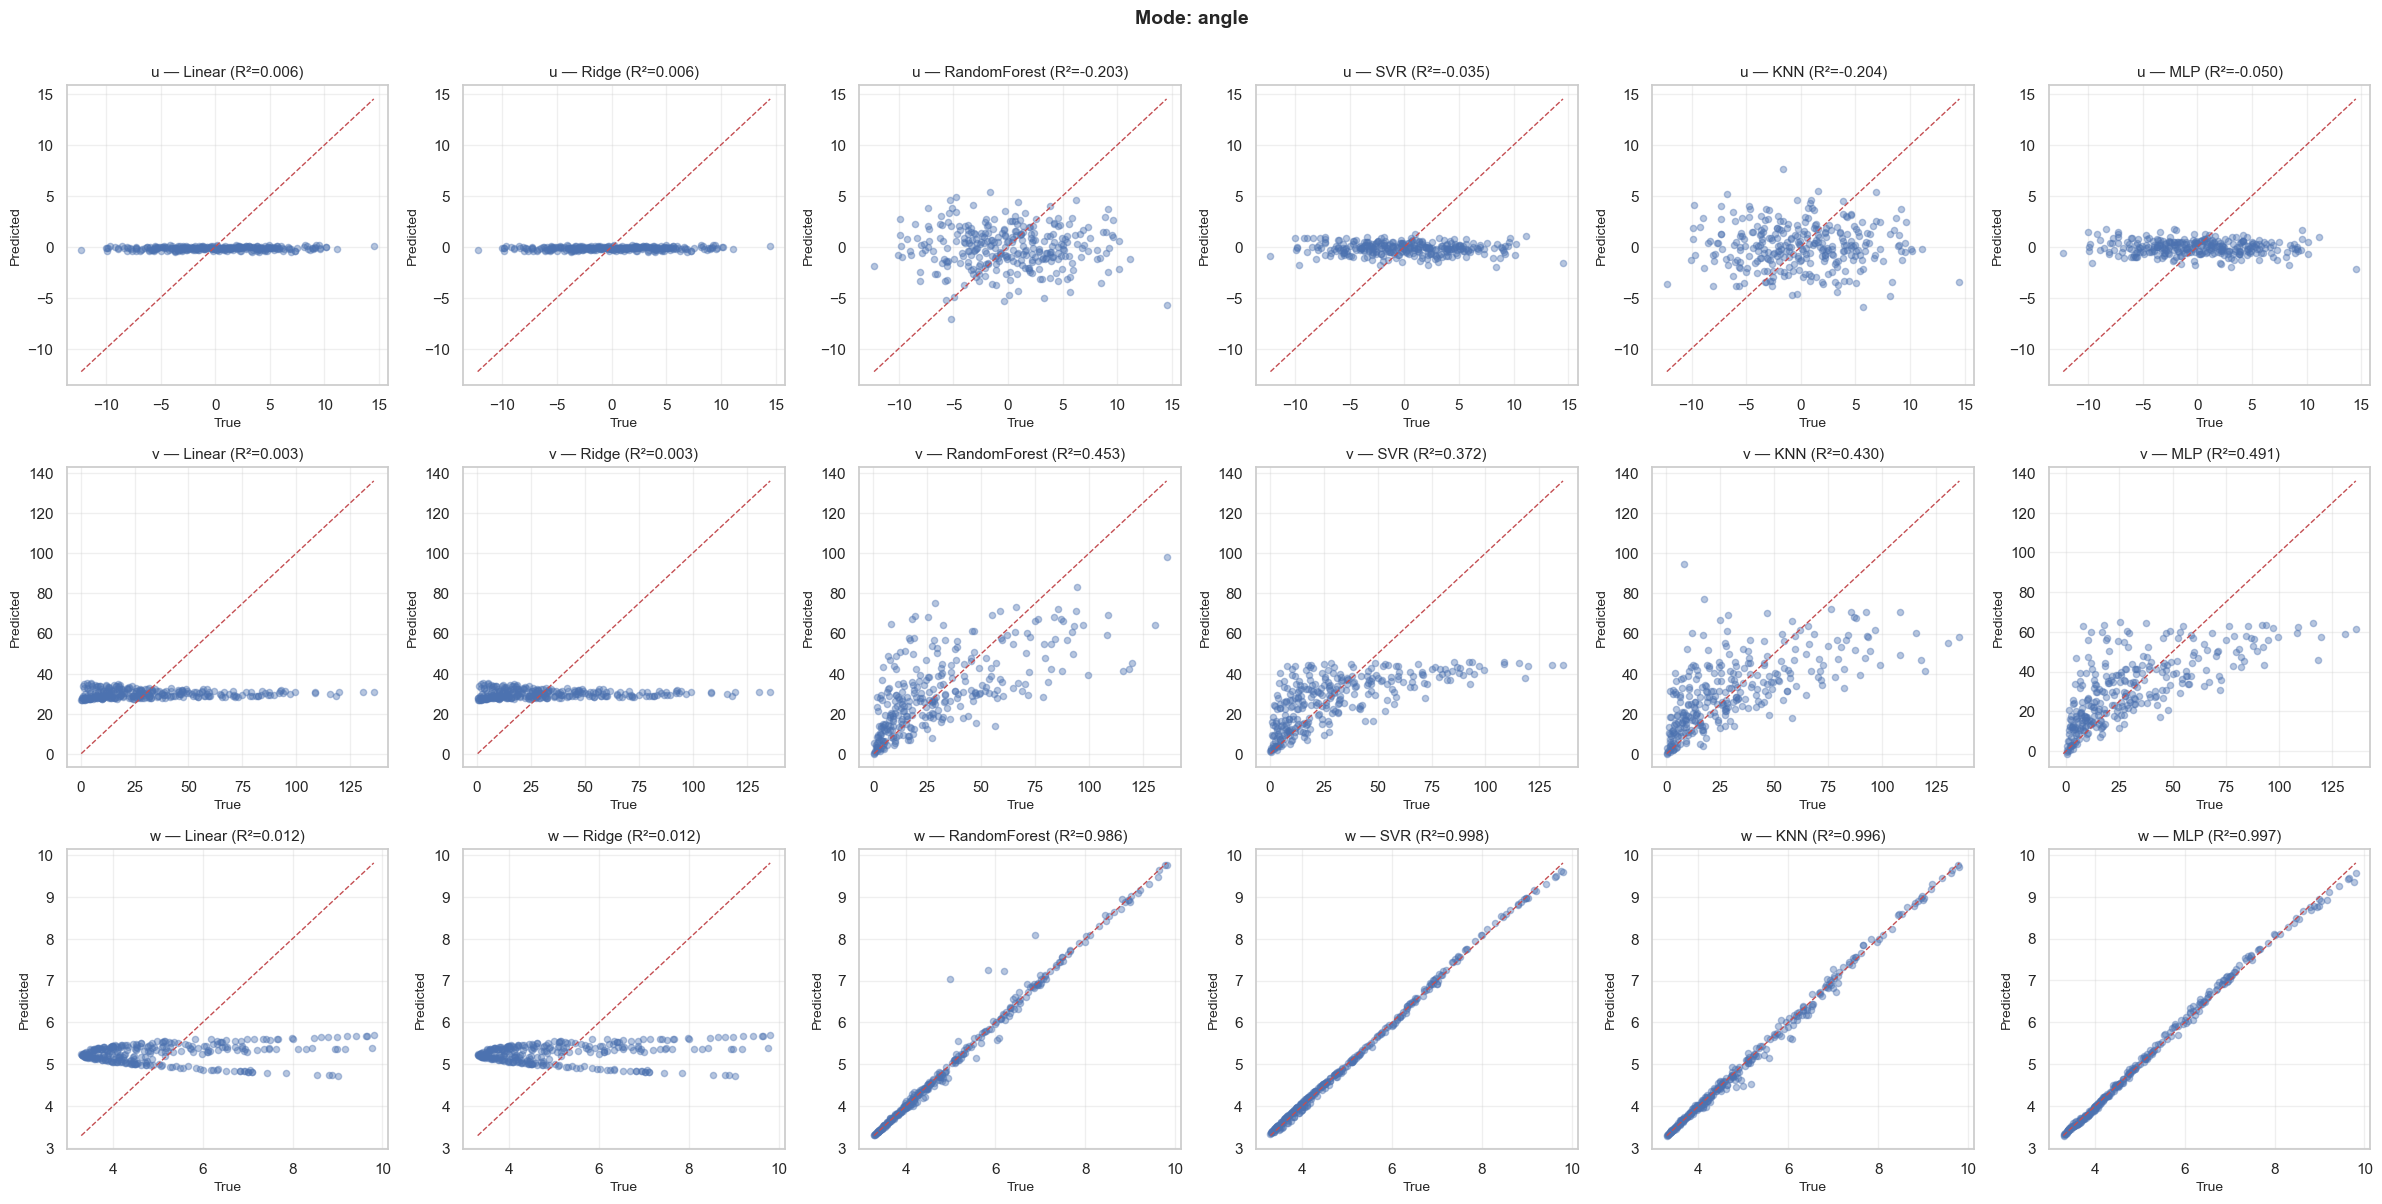


Summary across modes (first 20 rows):


,mode,target,regressor,MSE,MAE,R2
72,angle,u,Linear,22.222781,3.841035,0.005519
73,angle,u,Ridge,22.222886,3.841040,0.005515
75,angle,u,SVR,23.117924,3.903681,-0.034539
77,angle,u,MLP,23.465706,3.925119,-0.050102
74,angle,u,RandomForest,26.878457,4.149000,-0.202824
76,angle,u,KNN,26.899047,4.169301,-0.203746
83,angle,v,MLP,397.657861,14.512580,0.491389
80,angle,v,RandomForest,427.543255,15.066043,0.453165
82,angle,v,KNN,445.887068,15.031777,0.429703
81,angle,v,SVR,491.360499,15.497391,0.371542



Saved summary to regression_demo_summary.csv


In [8]:
# Section 9 — Main runnable example

N_SAMPLES = 1500
TEST_SIZE = 0.2
MODES_TO_RUN = ['none','congruent','similar','length','angle']
REGRESSORS_TO_USE = ['Linear','Ridge','SVR','KNN','RandomForest','MLP']

print('Generating dataset with', N_SAMPLES, 'samples...')
df = generate_triangle_dataset(n=N_SAMPLES, xmin=-10, xmax=10, ymin=-10, ymax=10, seed=1)
print('Generated', len(df), 'valid triangles (after rejecting degenerate samples)')

all_results = {}
all_plots_data = {}  # Store prediction data for combined plotting

for mode in MODES_TO_RUN:
    print('\n--- Running mode:', mode)
    X, y = get_features_and_targets(df, mode=mode)
    print('Features shape:', X.shape, 'Targets shape:', y.shape)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SIZE, random_state=0)
    regs = {k:v for k,v in build_regressors().items() if k in REGRESSORS_TO_USE}
    res, predictions = train_and_evaluate(Xtr, ytr, Xte, yte, regressors=regs, targets=['u','v','w'], out_prefix=f'results_{mode}')
    res['mode'] = mode
    all_results[mode] = res
    all_plots_data[mode] = predictions

    # Display results table for this mode
    display(res.sort_values(['target','R2'], ascending=[True,False]).reset_index(drop=True))

    # Create combined plot for this mode
    plot_predictions_combined(predictions, mode, targets=['u','v','w'])

# Concatenate summary table
summary = pd.concat(all_results.values(), ignore_index=True)
summary = summary[['mode','target','regressor','MSE','MAE','R2']]
print('\nSummary across modes (first 20 rows):')
display(summary.sort_values(['mode','target','R2'], ascending=[True,True,False]).head(20))

# Save a CSV for download or copying to Drive
summary.to_csv('regression_demo_summary.csv', index=False)
print('\nSaved summary to regression_demo_summary.csv')
